<img src='../../media/common/LogoWekeo_Copernicus_RGB_0.png' align='left' height='96px'></img>

<hr>

# Grassland Classification

*Authors: Adrian Di Paolo, Chung-Xiang Hong, Jonas Viehweger* 

This notebook will demonstrate how to clean up and pre process satellite data for a machine learning task. It will also go into detail on how to use the cleaned data to train, evaluate and select a model for a larger scale application. 

The task is to train a model which can classify grassland areas in the Netherlands. The ultimate goal would be to classify grasslands yearly to derive change maps of grassland loss and gain from them. To do the classification we are using phenological data and the EuroCrops Dataset as ground truth.

This notebook uses data that was already downloaded and prepared for Python in the previous notebook.

1. [Preprocessing Data](#preprocessing-data)

    - [Labeling Data](#labeling-the-data)

    - [Data Cleaning](#data-cleaning)

    - [Normalizing Dates](#normalizing-dates)

    - [Normalizing Numerical Data](#normalize-numerical-data)

    - [Split Dataset into Train and Test](#split-the-dataset-into-train-and-test) 

2. [Model Training](#model-training)

    
3. [Model Evaluation](#model-evaluation)

    - [Metrics](#metrics)

    - [Memory Usage](#memory-usage)

    - [Execution Time](#execution-time) 

    - [Confusion Matrix](#confusion-matrtix)

    - [ROC Curve](#roc-curve)
    
4. [Model Selection](#model-selection)

    - [Fine-tuning](#hyperparameter-optimization)

    - [Feature Importance](#feature-importance)

5. [Neural Network](#bonus-training-neural-network)



In [ ]:
import numpy as np
from numpy import load
import pandas as pd
import time
import psutil

from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

import seaborn as sns
import matplotlib.pyplot as plt

### Preprocessing Data


In [ ]:
# First we load the downloaded data
x_data = load('../../data/processing/ml-grassland-classification/dataset/x_data.npy')
y_data = load('../../data/processing/ml-grassland-classification/dataset/y_data.npy')

#### Labeling the data

We assign a 1 to the grassland label and 0 for others. 

In [3]:
def binary_label(y_data):
    """Assigns new labels: 1 if grassland, else 0"""
    binary_assign = np.vectorize(lambda x: 1 if x=='3302000000.0' else 0)
    y_data = y_data.astype(str)
    y_data = binary_assign(y_data)
    return y_data

#### Data cleaning

In our dataset we have Nan values or values that indicate No Data in the HRVPP documentation, so we delete the rows containing those values from the dataset.

In [4]:
def data_to_df(x_data, y_data=None):
    """Transform the data to dataframe and cleans it"""
    x_df = pd.DataFrame(x_data, columns = ['AMPL', 'EOSD', 'EOSV', 'LENGTH', 'LSLOPE', 'MAXD', 'MAXV', 'MINV', 'QFLAG', 'RSLOPE', 'SOSD', 'SOSV', 'SPROD', 'TPROD'])
    if y_data is not None:
        y_df = pd.DataFrame(y_data, columns=['LABEL'])
        df = x_df.join(y_df)
    else:
        df = x_df
    df = df.dropna()
    df = df[~(df[['EOSD', 'SOSD', 'MAXD', 'LENGTH']] == 0).any(axis=1)]
    df = df[~(df[['SOSV', 'EOSV', 'MAXV', 'MINV', 'AMPL', 'LSLOPE', 'RSLOPE']] == 32768).any(axis=1)]
    df = df[~(df[['SPROD', 'TPROD']] == 65535).any(axis=1)]
    return df

#### Normalizing Dates

As we are dealing with datasets that include columns with dates, it is essential to ensure that those columns are normalized. 

In our case, we have a dataset for different years that come with dates in the format 'YYDOY'. So the first two digits representing the year, and the last three digits representing the day of the year. As we need those dates to be consistent with other years, and also be in the same range, we transform them to a number representing the count of days since a reference date (1st of January of the previous year).

In [5]:
def transform_dates(df):
    """Transform dates columns from YYDOY to YY-MM-DD and then to the days since the 1 january of the previous year"""
    
    df[['EOSD', 'SOSD', 'MAXD']] = df[['EOSD', 'SOSD', 'MAXD']].astype(str)
    df[['SOSD', 'EOSD', 'MAXD']] = df[['SOSD', 'EOSD', 'MAXD']].apply(lambda x: pd.to_datetime(x, format='%y%j'))
    
    min_year = df['SOSD'].dt.year.min()
    reference_date = pd.Timestamp(year=min_year, month=1, day=1)
    df['SOSD'] = (df['SOSD'] - reference_date).dt.days
    df['EOSD'] = (df['EOSD'] - reference_date).dt.days
    df['MAXD'] = (df['MAXD'] - reference_date).dt.days
    return df

In [6]:
y_data = binary_label(y_data)
df = data_to_df(x_data, y_data)
df = transform_dates(df)

#### Normalize numerical data

For the columns that contain numerical data, we should ensure the data range is normalized in case the data has different scales. This process may improve the models performance, and also preserve outliers.

In [7]:
scaler = MinMaxScaler()

columns_to_scale  = df.drop(['LABEL', 'MAXD', 'SOSD', 'EOSD'], axis=1)
df_scaled = pd.DataFrame(scaler.fit_transform(columns_to_scale), columns = columns_to_scale.columns)
df = df.reset_index(drop=True)
df_scaled = pd.concat([df_scaled, df[['LABEL', 'MAXD', 'SOSD', 'EOSD']]], axis=1)

In [8]:
x_data = df_scaled.drop(columns=['LABEL'])
y_data = df_scaled['LABEL']

##### Split Dataset into Train and Test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20, random_state=42)

#### Undersampling Dataset

Undersampling is a technique used to balance imbalanced datasets, where one class has significantly more samples than another class.

The main advantage of undersampling is that it can improve the performance of classifiers by reducing the bias towards the majority class, which can lead to better predictions on the minority class. Undersampling can also reduce the training time and memory requirements of the model, since there are fewer instances to process.

In [10]:
# Compute class distribution before undersampling
class_counts_before = pd.Series(y_train).value_counts()

In [11]:
undersampler = RandomUnderSampler(sampling_strategy='majority')
X_train, y_train = undersampler.fit_resample(X_train, y_train)

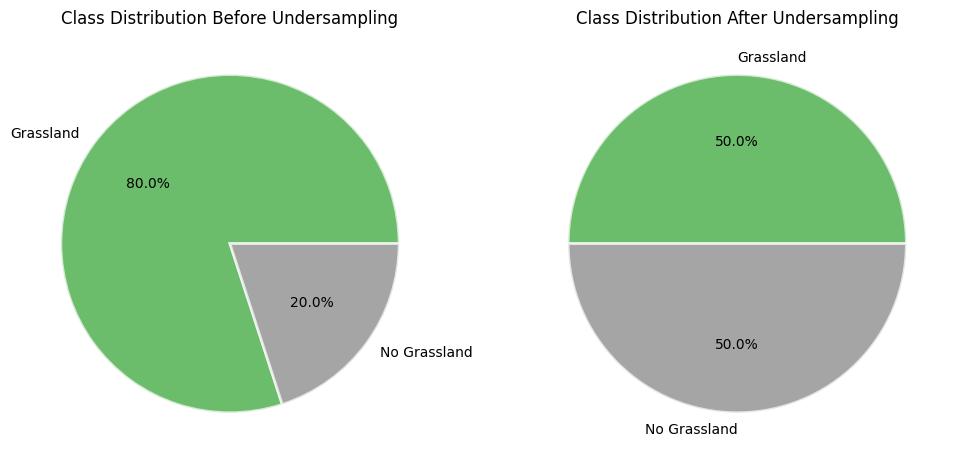

In [12]:
# Compute class distribution after undersampling
class_counts_after = pd.Series(y_train).value_counts()

# Create figure with subplots
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

# Create pie chart on first subplot
axes[0].pie(class_counts_before, labels=['Grassland', 'No Grassland'], autopct='%1.1f%%', colors=['tab:green', 'tab:grey'],
              wedgeprops={'linewidth': 2, 'edgecolor': 'white', 'alpha': 0.7})
axes[0].set_title('Class Distribution Before Undersampling')

# Create pie chart on second subplot
axes[1].pie(class_counts_after, labels=['Grassland', 'No Grassland'], autopct='%1.1f%%', colors=['tab:green', 'tab:grey'],
              wedgeprops={'linewidth': 2, 'edgecolor': 'white', 'alpha': 0.7})
axes[1].set_title('Class Distribution After Undersampling')

# Adjust spacing between subplots
#plt.subplots_adjust(wspace=0.4)

# Show the plot
plt.show()

### Model Training

Here we are testing quite a few different algorithms on their performance for the task. 
It has to be noted that this is a quite naive and brute force approach to the task, since the models hyperparameters aren't tweaked and no pre-selection of machine learning algorithms based on expert knowledge is made. 

However it will give a rough idea on the performance of the algorithms and in addition it will provide information on the computational efficiency of the algorithms in terms of memory usage and computation time. These are also important parameters to consider when scaling the model up.

In [13]:
models = {}

# Logistic Regression
models['Logistic Regression'] = LogisticRegression(max_iter=1000, n_jobs=4)

# Support Vector Machines
models['Support Vector Machines'] = LinearSVC(dual=False)

# Decision Trees
models['Decision Trees'] = DecisionTreeClassifier(random_state=42)

# Random Forest
#models['Random Forest'] = RandomForestClassifier(n_jobs=4, random_state=42)

# Naive Bayes
models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors
models['K-Nearest Neighbor'] = KNeighborsClassifier(n_jobs=4)

# LightGBM
models['Lightgbm'] = LGBMClassifier(n_jobs=4, random_state=42)

# Metrics
accuracy, precision, recall, f1, memory_usage, time_usage = {}, {}, {}, {}, {}, {}

In [14]:
for key in models.keys():
    
    # Fit the classifier model
    start_time = time.time()
    start_mem = psutil.Process().memory_info().rss / 1024 / 1024 # in MB
    models[key].fit(X_train, y_train)
    end_time = time.time()
    end_mem = psutil.Process().memory_info().rss / 1024 / 1024 # in MB
    
    # Prediction 
    predictions = models[key].predict(X_test)
    elapsed_time = end_time - start_time
    mem_usage = end_mem - start_mem
    info_text = f'Time: {elapsed_time:.2f} s\nMemory: {mem_usage:.2f} MB'

    # Calculate Accuracy, Precision and Recall, F1-Score, and Memory and Usage Metrics
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)
    f1[key] = f1_score(predictions, y_test)
    memory_usage[key] = mem_usage
    time_usage[key] = elapsed_time

### Model Evaluation

##### Metrics

In [15]:
def plot_dict(data, title, x_label, y_label):
    df = pd.DataFrame.from_dict(data, orient='index', columns=['metric'])

    # Sort the DataFrame by the metric column
    df = df.sort_values(by='metric')

    # Create a color map for the bars
    # Create a color palette for the bars
    colors = sns.color_palette("Greens", len(data))

    # Set the style and context using sns.set()
    sns.set(style="whitegrid", context="notebook")
    ax = sns.barplot(x='metric', y=df.index, data=df, palette=colors)

    # Add a title and axis labels
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Display the plot
    plt.show()

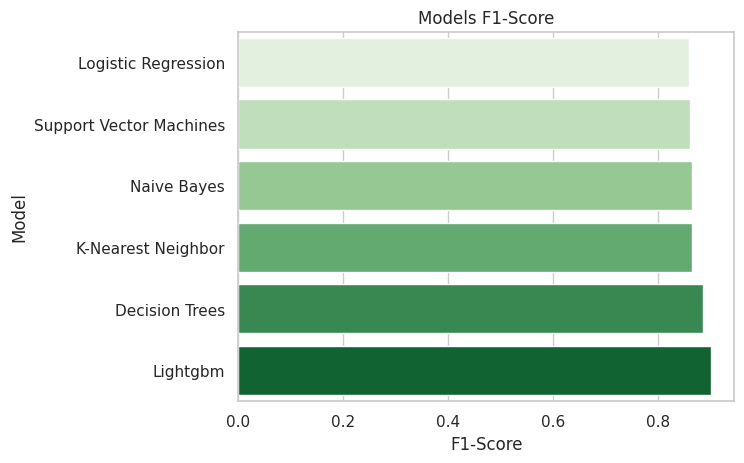

In [16]:
plot_dict(f1, 'Models F1-Score', 'F1-Score', 'Model')

##### Memory Usage

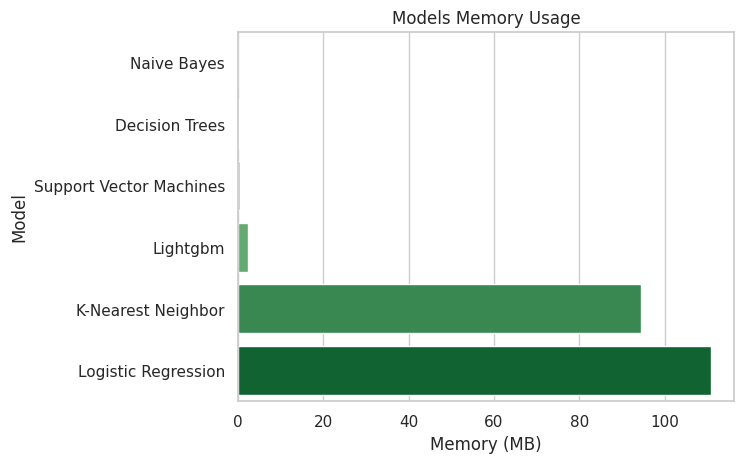

In [17]:
plot_dict(memory_usage, 'Models Memory Usage', 'Memory (MB)', 'Model')

##### Execution Time

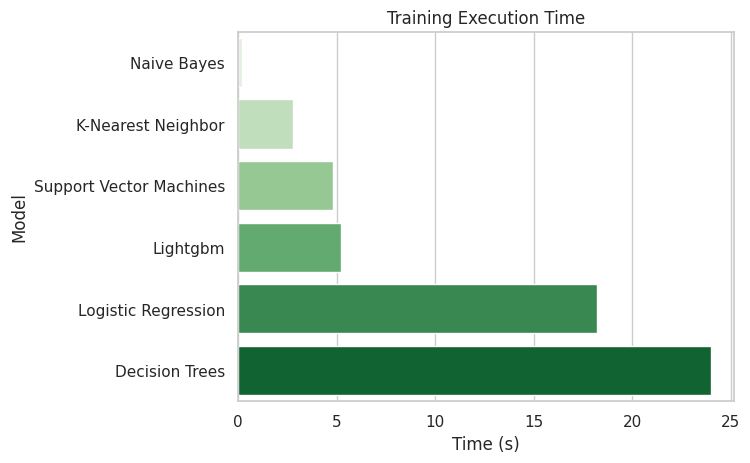

In [18]:
plot_dict(time_usage, 'Training Execution Time', 'Time (s)', 'Model')

As we can see, the Lightgbm and the RandomForest are the two models that get better results, but in terms of time and memory usage the Lightgbm model is by far the more efficient.

#### Loading Validation Dataset

Now we will prove this model with the validation dataset, which was taken from a different bounding box area. This will give us the performance of the model on data which hasn't been seen during the training. If the performance of the model is much worse for this dataset, it means that the model has been overfit on the training data and isn't general enough to get a good performance on new data.

We also have to pre-process the validation data them with the sane steps as explained before. 

In [19]:
x_validation = load('../../data/processing/ml-grassland-classification/dataset/x_validation.npy')
y_validation = load('../../data/processing/ml-grassland-classification/dataset/y_validation.npy')

In [20]:
y_validation = binary_label(y_validation)
df_validation = data_to_df(x_validation, y_validation)
df_validation = transform_dates(df_validation)

In [21]:
v_columns_to_scale  = df_validation.drop(['LABEL', 'MAXD', 'SOSD', 'EOSD'], axis=1)
scaled_validation_data = scaler.transform(v_columns_to_scale)
scaled_validation_data = pd.DataFrame(scaled_validation_data, columns=v_columns_to_scale.columns)
df_validation = df_validation.reset_index(drop=True)
df_validation = pd.concat([scaled_validation_data, df_validation[['LABEL', 'MAXD', 'SOSD', 'EOSD']]], axis=1)

In [22]:
x_validation = df_validation.drop(columns=['LABEL'])
y_validation = df_validation['LABEL']

For evaluating the models performance in the validation dataset, we will use confusion matrices and ROC curves. 

#### Confusion Matrtix

A confusion matrix is a table that summarizes the performance of a classification model by comparing the predicted labels with the true labels of a set of data. 

The confusion matrix consists of four values: true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN). The rows of the matrix represent the actual labels, while the columns represent the predicted labels. The diagonal elements of the matrix represent the instances that are classified correctly, while the off-diagonal elements represent the instances that are misclassified.

In [23]:
def plot_confusion_matrices(models, X_test, y_test):
    num_models = len(models)
    nrows = (num_models + 2) // 3
    ncols = min(num_models, 3)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5*nrows))
    class_names = ['Grassland', 'No Grassland']
    for i, model in enumerate(models):
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred, normalize='true')  # normalize the confusion matrix
        
        row = i // ncols
        col = i % ncols
        ax = axs[row][col]
        sns.heatmap(cm, annot=True, cmap='Greens', fmt='.2f', xticklabels=class_names, yticklabels=class_names, cbar=False, ax=ax, annot_kws={"color": "black"})
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
        ax.set_title(type(model).__name__)
    
    if num_models % 3 != 0:
        for i in range(num_models % 3, 3):
            axs[-1][i].axis('off')
    
    plt.tight_layout()
    plt.show()

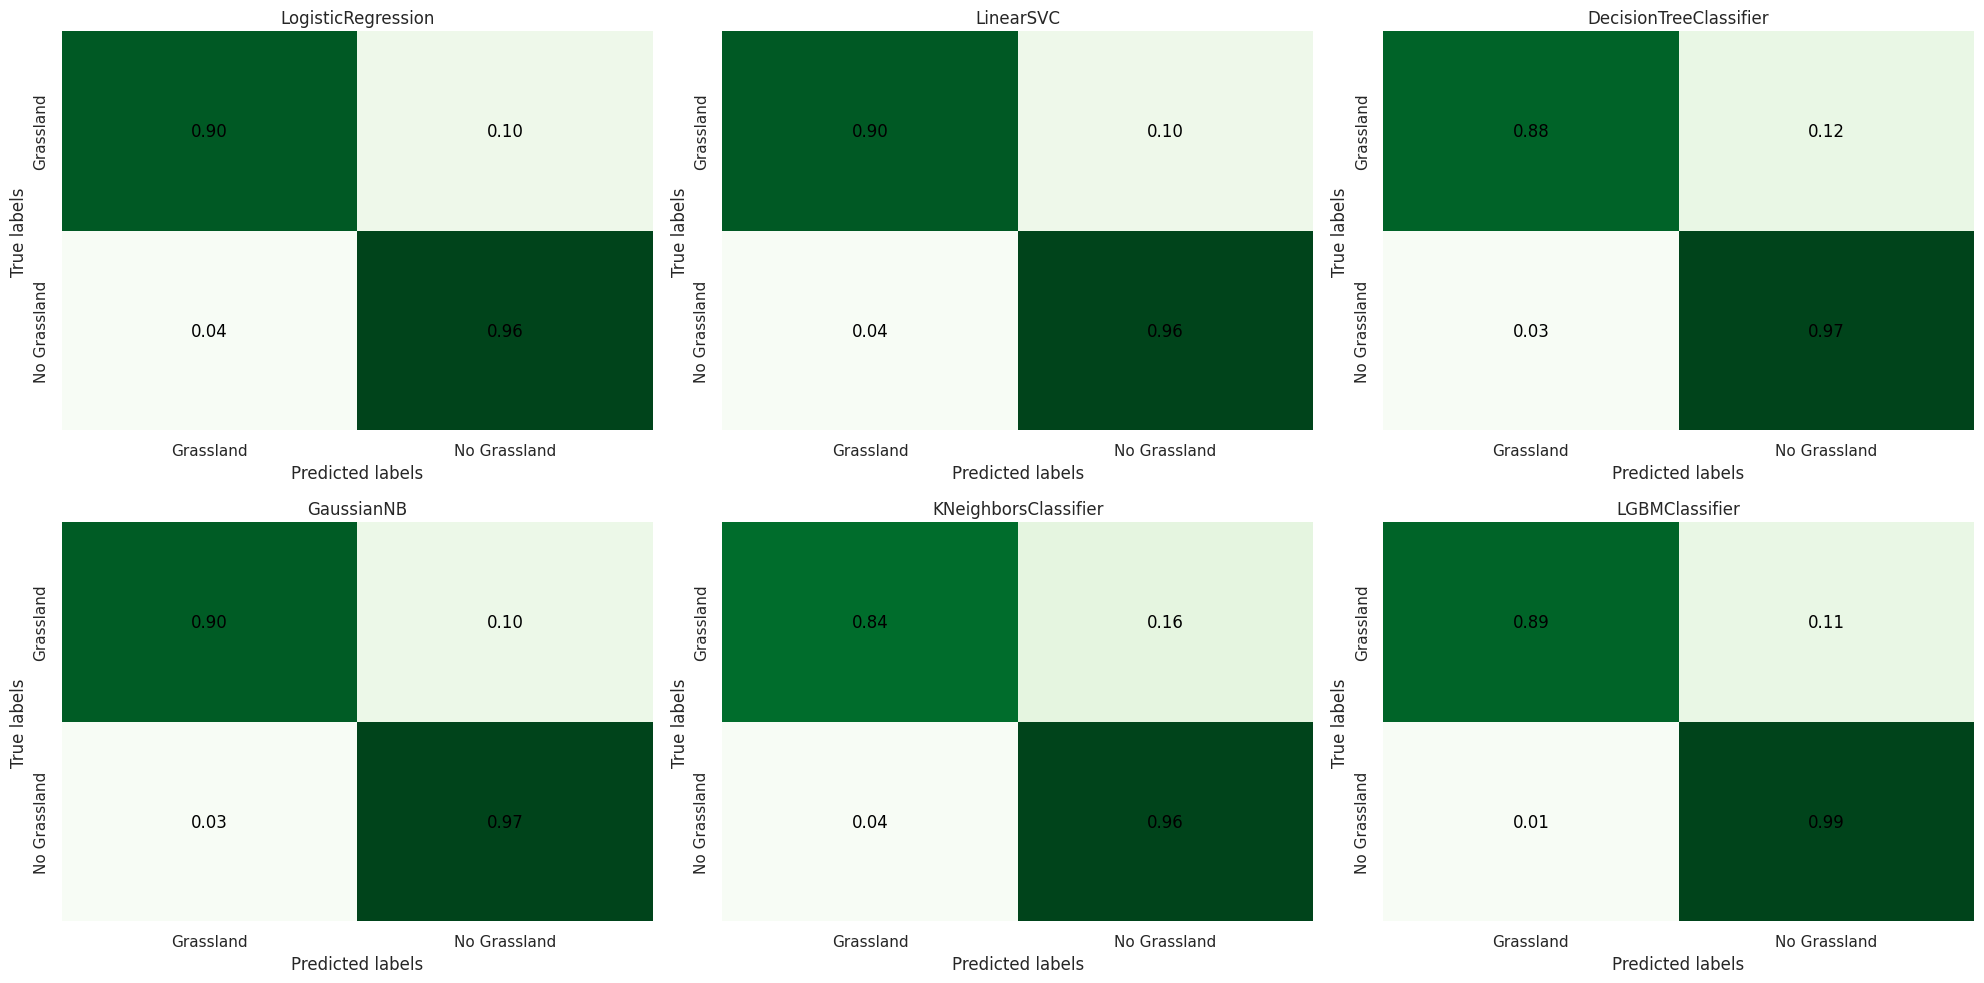

In [24]:
plot_confusion_matrices(list(models.values()), x_validation, y_validation)

#### ROC Curve

The ROC (Receiver Operating Characteristic) curve is a graphical representation of the performance of a binary classifier. The ROC curve shows the trade-off between the true positive rate (TPR), also called sensitivity or recall, and the false positive rate (FPR), which is the proportion of negative instances that are incorrectly classified as positive.

To create a ROC curve, the classifier's output is sorted by confidence or probability, and the threshold for classification is varied from high to low. At each threshold value, the TPR and FPR are calculated and plotted on a graph with TPR on the y-axis and FPR on the x-axis. The resulting curve represents the classifier's performance at all possible threshold values.

The closer the curve is to the top-left corner of the graph, the better the classifier's performance, as this indicates a high TPR and a low FPR. The area under the ROC curve (AUC) is a commonly used metric to summarize the classifier's performance. A perfect classifier would have an AUC of 1, while a random classifier would have an AUC of 0.5.

In [25]:
def plot_roc_curve(models, X_test, y_test, labels, figsize=(8, 6)):
    plt.figure(figsize=figsize)
    for model, label in zip(models, labels):
        if label != 'Support Vector Machines':
            y_prob = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
        else:
            y_score = model.decision_function(X_test)
            fpr, tpr, _ = roc_curve(y_test, y_score)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

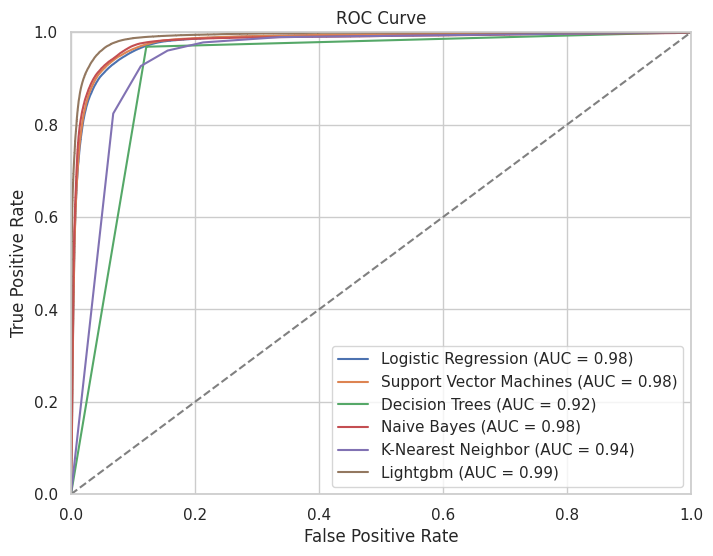

In [26]:
plot_roc_curve(list(models.values()), x_validation, y_validation, list(models.keys()))

### Model Selection

As we can see for the previous metrics, memory and time usage, the best candidate to solve this binary classification problem is the LightGBM model.

LightGBM is a popular open-source gradient boosting framework that was developed by Microsoft. It is designed to be highly efficient in terms of training speed and memory usage, making it a popular choice for large-scale machine learning tasks. LightGBM uses gradient boosting algorithms to build models, which iteratively improves the performance of a weak learner by adding new decision trees to the ensemble.

In [27]:
lgbm = LGBMClassifier(n_jobs=4, random_state=42)

##### Hyperparameter Optimization

GridSearchCV is a technique used to fine-tune the hyperparameters in order to improve its performance. In essence, it involves searching over a range of values for each hyperparameter and finding the combination that yields the best results.

In [28]:
# Define a dictionary of hyperparameters to search over
param_grid = {
    'learning_rate': [0.1, 0.01],
    'num_leaves': [200, 300],
    'max_depth': [7, 10, 14]
}

# Define a grid search object with the LGBM classifier and hyperparameters to search over
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=5, scoring='f1')

# Fit the grid search object to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and their corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best f1 score:", grid_search.best_score_)


Best parameters: {'learning_rate': 0.1, 'max_depth': 14, 'num_leaves': 300}
Best f1 score: 0.9674807188216772


In [29]:
lgbm = LGBMClassifier(**grid_search.best_params_, n_jobs=4, random_state=42)

In [30]:
lgbm.fit(X_train, y_train)

LGBMClassifier(max_depth=14, n_jobs=4, num_leaves=300, random_state=42)

In [31]:
lgbm.score(X_test, y_test)

0.9645099689573096

In [32]:
lgbm.score(x_validation, y_validation)

0.9291435005982124

In [33]:
y_pred = lgbm.predict(x_validation)

In [34]:
f1_score(y_validation, y_pred)

0.9071671599679124

##### Feature Importance
One way to gain insight into the relative importance of features is to use the feature_importances_ attribute. This is useful to understand which features were most important in predicting the target variable. 

In [35]:
feature_importances = dict(zip(["AMPL","EOSD","EOSV","LENGTH","LSLOPE","MAXD","MAXV","MINV","QFLAG","RSLOPE","SOSD","SOSV","SPROD","TPROD"], lgbm.feature_importances_))

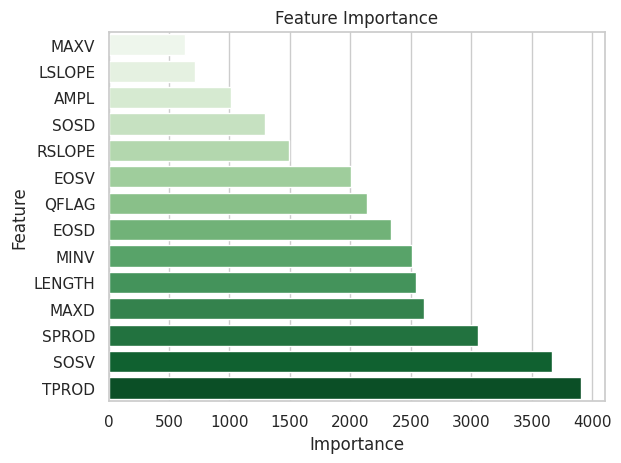

In [36]:
plot_dict(feature_importances, 'Feature Importance', 'Importance', 'Feature')

In [37]:
def plot_confusion_matrix(y_validation, y_pred):
    class_names = ['GrassLand', 'No Grassland']
    cm = confusion_matrix(y_validation, y_pred, labels=[1, 0], normalize='true')
    sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, cmap='Greens')

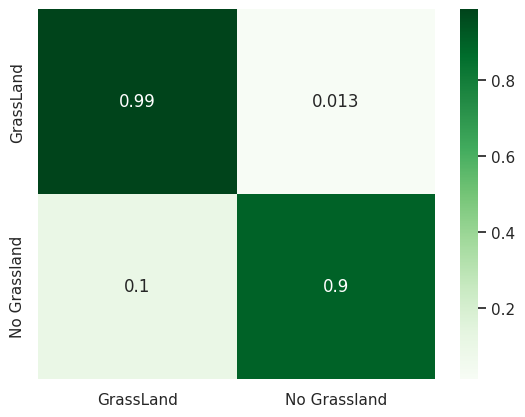

In [38]:
plot_confusion_matrix(y_validation, y_pred)

### Conclusions

After completing this first machine learning workflow for a limited area, we can draw several conclusions:

- **The best-performing models for this case were the Random Forest and the LightGBM, both tree-based ML algorithms.** 

- **Our preferred choice for this case is LightGBM, primarily due to its superior speed and memory efficiency, as well as its ability to effectively handle multi-dimensional datasets.**

- **Training the model with limited areas may lead to overfitting due to the correlation between adjacent pixels. In order to address this issue, our upcoming step involves scaling up the analysis and implementing measures to reduce the impact of adjacent pixel correlation.**




### Bonus: Training Neural Network 

This is just a bonus showing a quick demonstration of using a neural network for this classification task. The focus of this notebook is not on neural nets, but anyway it might be an interesting starting point for further exploration of this area of machine learning.

In [39]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential() 
model.add(Dense(64, activation='relu', input_dim=14))
model.add(Dense(64, activation='relu', input_dim=14))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                960       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,185
Trainable params: 5,185
Non-trainable params: 0
_________________________________________________________________


In [40]:
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=100)

Epoch 1/20
8839/8839 [==============================] - 20s 2ms/step - loss: 0.2967 - accuracy: 0.8963 - val_loss: 0.1842 - val_accuracy: 0.9331
Epoch 2/20
8839/8839 [==============================] - 22s 2ms/step - loss: 0.2122 - accuracy: 0.9228 - val_loss: 0.1504 - val_accuracy: 0.9448
Epoch 3/20
8839/8839 [==============================] - 18s 2ms/step - loss: 0.1953 - accuracy: 0.9302 - val_loss: 0.1874 - val_accuracy: 0.9345
Epoch 4/20
8839/8839 [==============================] - 21s 2ms/step - loss: 0.1871 - accuracy: 0.9337 - val_loss: 0.1443 - val_accuracy: 0.9481
Epoch 5/20
8839/8839 [==============================] - 22s 2ms/step - loss: 0.1778 - accuracy: 0.9371 - val_loss: 0.1544 - val_accuracy: 0.9421
Epoch 6/20
8839/8839 [==============================] - 21s 2ms/step - loss: 0.1738 - accuracy: 0.9387 - val_loss: 0.1854 - val_accuracy: 0.9360
Epoch 7/20
8839/8839 [==============================] - 21s 2ms/step - loss: 0.1704 - accuracy: 0.9397 - val_loss: 0.1637 - val_ac

In [ ]:
sns.set()
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()